# DESAFIO: EXPANSÃO DE UMA REDE DE LABORATÓRIOS

## O Cenário

A medicina diagnóstica tem um papel fundamental na jornada de atendimento dos pacientes
de qualquer sistema de saúde em qualquer lugar do mundo, sendo somente nos EUA um
mercado de aproximadamente 106 bilhões de dólarers com mais de 40 mil laboratórios,
empregando mais de 680 mil funcionários segundo a [ACLA](https://www.acla.com/economic-impact-of-clinical-labs/).

## O Problema

Diante desse cenário, o desafio proposto tem como objetivo auxiliar a área de negócios de
uma rede norte americana de medicina diagnóstica a ter insumos iniciais para suportar seu
plano de expansão da rede de laboratórios. Sabe-se que não é possível ou é bem difícil gerar
demanda e fazer ofertas neste tipo de mercado, entretanto é muito interessante e rentável
fidelizar o cliente para que ele sempre visite a rede quando surgir a necessidade.

## A Tarefa

O que esperamos nesse momento é que você, como Cientista de Dados responsável pelo
projeto apresente uma Análise Exploratória dos Dados, defina caminhos de abordagem para
o problema em questão, apresente e JUSTIFIQUE a escolha de TRÊS ZIP CODES para a
instalação dos novos laboratórios da rede. Utilize as bases de dados disponibilizadas e
exponha seus resultados em uma apresentação clara e objetiva, incluindo todos os
comentários que achar relevante.

## As Bases

* **transactional_data.csv** – Um arquivo contendo os registros de exames feitos por pacientes
da rede em cada laboratório
* **test_data.csv** – Um arquivo contendo informações a respeito dos exames, suas características
como custo de realizacão e outras especificações técnicas
* **df_geocode.csv** – Um arquivo contendo informações a respeito da localização de cada um
dos laboratórios, como endereço,latlong, e o Zip code no qual o laboratório está inserido.
* **dicionario.xlsx** – Um dicionário relacionando a descrição de variáveis das tabelas acima
* **Health insurance data for ZCTAs** – Um zip contendo dados sobre cobertura de plano de saúde
dentre outras estatísticas relevantes (acompanha dicionário de dados) a nível de ZCTAs (Zip
code tabulation area. Mais informações sobre ZCTAs [aqui ](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/zctas.html)
* **Economic data for ZCTAs** - Um zip contendo dados econômicos e de empregabilidade dentre
outras estatísticas relevantes (acompanha dicionário de dados) a nível de ZCTAs (Zip code
tabulation area)
* **Demographic data for ZCTAs** - Um zip contendo dados econômicos demográficos dentre
outras estatísticas relevantes (acompanha dicionário de dados) a nível de ZCTAs (Zip code
tabulation area)

## Pontos Esperados

   1) Mostrar todos os tratamentos necessários para sanitização de dados.  
   2) Criar uma abordagem com possíveis caminhos para resolver o problema em questão.  
   3) Criar uma apresentação com sua abordagem para resolver o problema e apresentar seus resultados, levantando e destacando a sua **aplicabilidade**, **efetividade** e **limitações** para solucionar o problema de negócios em questão.  
   4) Incluir qualquer outra informação/análise que achar importante.  

# Introdução

Autor: [Bruno Silva](https://github.com/bgsilva)

Data: 31/01/2022

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

# Preparação dos dados

## Preprocessamento dos dados

Inicialmente, vamos verificar os principais datasets utilizados na análise ('transactional_data.csv', 'test_data.csv' e 'df_geocode.csv') e checar a consistência dos dados.

Vamos iniciar pelo dataset 'transactional_data.csv':

In [2]:
df_trans_data = pd.read_csv('dados/transactional_data.csv', sep=';', decimal=',')
print(df_trans_data.shape)
df_trans_data.head()

(2355241, 8)


,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
0,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70003237,9.0
1,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000638,13.0
2,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70001597,49.0
3,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000103,11.0
4,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000224,10.0


O dataset 'transactional_data.csv' contém os registros de exames feitos por pacientes da rede em cada laboratório.

* Patient Id: Id do Paciente
* Gender: Sexo do paciente
* Date of birth: Data de Nascimento do Cliente
* Date of service: Data em que o exame aconteceu
* Service Id: O Id do serviço
* Lab Id: o Id do laboratório em que o paciente fez o exame
* CodItem: O código do exame que o cliente fez
* Testing Cost: O valor pago pelo exame

Verificando as informações básicas do dataset:

In [3]:
df_trans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355241 entries, 0 to 2355240
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Patient Id       object 
 1   Gender           object 
 2   Date of birth    object 
 3   Date of service  object 
 4   Service Id       object 
 5   Lab Id           object 
 6   CodItem          int64  
 7   Testing Cost     float64
dtypes: float64(1), int64(1), object(6)
memory usage: 143.8+ MB


Criação de uma nova coluna 'Age' com a idade do paciente:

In [4]:
# Transformar a series 'Date of birth' para o tipo datetime
df_trans_data['Date of birth'] = pd.to_datetime(df_trans_data['Date of birth'], format="%d/%m/%Y %H:%M:%S")

In [5]:
# Função criada para encontrar a idade a partir da coluna 'Date of birth'
from datetime import date

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [6]:
# Criação da nova coluna 'Age'
df_trans_data['Age'] = [calculate_age(x) for x in df_trans_data['Date of birth']]

Verificando dados faltantes:

In [7]:
df_trans_data_data_isnull_list = df_trans_data.isnull().sum()
for key, value in df_trans_data_data_isnull_list.iteritems():
    print(key,":",value)

Patient Id : 0
Gender : 0
Date of birth : 1
Date of service : 0
Service Id : 0
Lab Id : 0
CodItem : 0
Testing Cost : 0
Age : 1


Temos apenas um dado faltante relativo a uma data de nascimento. Como trata-se de apenas um único valor, vamos excluir a linha correspondente:

In [8]:
df_trans_data = df_trans_data.dropna()

---

Agora vamos checar o dataset 'test_data.csv':

In [9]:
df_test_data = pd.read_csv('dados/test_data.csv', sep=';', decimal=',')
print(df_test_data.shape)
df_test_data.head()

(2002, 6)


,CodItem,Desc Item,Category,Family,Speciality,Testing Cost
0,70003237,"MAGNESIO, SORO (EXEMPLO DE EXPRESSAO DE RESULT...",CA,CORELAB,BIOCHEMISTRY,1.78
1,70000638,"HEMOGRAMA, AUTOMATIZADO, SANGUE",CA,HEMATO,BLOOD COUNT,2.46
2,70001597,"FERRITINA, SORO",CA,CORELAB,IMMUNOHORMONE,2.11
3,70000103,"FERRO, DOSAGEM, SORO (EXEMPLO DE EXPRESSAO DE ...",CA,Corelab,BIOCHEMISTRY,0.80
4,70000224,"CALCIO, DOSAGEM, SORO (EXEMPLO DE EXPRESSAO DE...",CA,CORELAB,BIOCHEMISTRY,1.02


O dataset 'test_data.csv' contém informações a respeito dos exames, suas características como custo de realizacão e outras especificações técnicas.

* CodItem: O código do exame que o cliente fez
* Desc Item: A descrição traduzida do exame
* Category: Categoria traduzida do exame
* Family: Família traduzida do exame
* Speciality: Especialidade traduzida do exame
* Testing Cost: Custo operacional para realizar o exame

Verificando as informações básicas do dataset:

In [10]:
df_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002 entries, 0 to 2001
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CodItem       2002 non-null   int64  
 1   Desc Item     2002 non-null   object 
 2   Category      2002 non-null   object 
 3   Family        2002 non-null   object 
 4   Speciality    2002 non-null   object 
 5   Testing Cost  2002 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 94.0+ KB


Verificando dados faltantes:

In [11]:
df_test_data_isnull_list = df_test_data.isnull().sum()
for key, value in df_test_data_isnull_list.iteritems():
    print(key,":",value)

CodItem : 0
Desc Item : 0
Category : 0
Family : 0
Speciality : 0
Testing Cost : 0


O dataset 'test_data.csv' não apresenta dados faltantes.

---

Agora vamos checar o dataset 'df_geocode.csv':

In [12]:
df_geocode = pd.read_csv('dados/df_geocode.csv', sep=';')
print(df_geocode.shape)
df_geocode.head()

(119, 4)


,Lab Id,Address,location,zipcode
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30044
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469


O dataset contém informações a respeito da localização de cada um dos laboratórios, como endereço,latlong, e o Zip code no qual o laboratório está inserido.

* Lab Id: o Id do laboratório em que o paciente fez o exame
* Address: Endereço do Laboratório
* location: Latitude e longitude da localização do laboratório
* zipcode: O Código postal de onde o laboratório está

Checando as informações básicos do dataset:

In [13]:
df_geocode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Lab Id    119 non-null    object
 1   Address   119 non-null    object
 2   location  119 non-null    object
 3   zipcode   119 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 3.8+ KB


Verificando a existência de dados faltantes:

In [14]:
df_geocode_isnull_list = df_geocode.isnull().sum()
for key, value in df_geocode_isnull_list.iteritems():
    print(key,":",value)

Lab Id : 0
Address : 0
location : 0
zipcode : 0


O dataset não apresentam dados faltantes.

Para as análises, será necessário separar latitude e longitude:

In [15]:
df_geocode[['Latitude', 'Longitude']] = df_geocode['location'].str.strip('()').str.split(',', expand=True).rename(columns={0:'Latitude', 1:'Longitude'}) 
print(df_geocode.shape)
df_geocode.head()

(119, 6)


,Lab Id,Address,location,zipcode,Latitude,Longitude
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30044,34.000319,-84.1629724
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440,43.2311327,-75.4445363
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034,47.7162786,-122.1838152
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342,33.9093875,-84.3529096
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469,40.9309925,-90.9437598


---

Por últimos, vamos checar o dataset 'ACSDP5Y2019.DP05_data_with_overlays_2021-07-22T145324.csv':

In [16]:
df_pop = pd.read_csv('dados/ACSDP5Y2019.DP05_data_with_overlays_2021-07-22T145324.csv', sep=',', low_memory=False)

print(df_pop.shape)
df_pop.head()

(33121, 358)


,GEO_ID,NAME,DP05_0001E,DP05_0001M,DP05_0001PE,DP05_0001PM,DP05_0002E,DP05_0002M,DP05_0002PE,DP05_0002PM,...,DP05_0087PE,DP05_0087PM,DP05_0088E,DP05_0088M,DP05_0088PE,DP05_0088PM,DP05_0089E,DP05_0089M,DP05_0089PE,DP05_0089PM
0,id,Geographic Area Name,Estimate!!SEX AND AGE!!Total population,Margin of Error!!SEX AND AGE!!Total population,Percent!!SEX AND AGE!!Total population,Percent Margin of Error!!SEX AND AGE!!Total po...,Estimate!!SEX AND AGE!!Total population!!Male,Margin of Error!!SEX AND AGE!!Total population...,Percent!!SEX AND AGE!!Total population!!Male,Percent Margin of Error!!SEX AND AGE!!Total po...,...,"Percent!!CITIZEN, VOTING AGE POPULATION!!Citiz...","Percent Margin of Error!!CITIZEN, VOTING AGE P...","Estimate!!CITIZEN, VOTING AGE POPULATION!!Citi...","Margin of Error!!CITIZEN, VOTING AGE POPULATIO...","Percent!!CITIZEN, VOTING AGE POPULATION!!Citiz...","Percent Margin of Error!!CITIZEN, VOTING AGE P...","Estimate!!CITIZEN, VOTING AGE POPULATION!!Citi...","Margin of Error!!CITIZEN, VOTING AGE POPULATIO...","Percent!!CITIZEN, VOTING AGE POPULATION!!Citiz...","Percent Margin of Error!!CITIZEN, VOTING AGE P..."
1,8600000US35004,ZCTA5 35004,12045,725,12045,(X),5840,477,48.5,2.5,...,8933,(X),4203,353,47.1,2.3,4730,357,52.9,2.3
2,8600000US35005,ZCTA5 35005,7344,579,7344,(X),3397,309,46.3,2.7,...,5534,(X),2471,220,44.7,2.9,3063,342,55.3,2.9
3,8600000US35006,ZCTA5 35006,2883,361,2883,(X),1498,228,52.0,3.0,...,2296,(X),1151,173,50.1,3.3,1145,154,49.9,3.3
4,8600000US35007,ZCTA5 35007,26332,1027,26332,(X),12827,607,48.7,1.5,...,18205,(X),8810,537,48.4,1.7,9395,474,51.6,1.7


Removendo a primeira linha (redundante):

In [17]:
df_pop = df_pop.drop(labels=0, axis=0)

df_pop.head()

,GEO_ID,NAME,DP05_0001E,DP05_0001M,DP05_0001PE,DP05_0001PM,DP05_0002E,DP05_0002M,DP05_0002PE,DP05_0002PM,...,DP05_0087PE,DP05_0087PM,DP05_0088E,DP05_0088M,DP05_0088PE,DP05_0088PM,DP05_0089E,DP05_0089M,DP05_0089PE,DP05_0089PM
1,8600000US35004,ZCTA5 35004,12045,725,12045,(X),5840,477,48.5,2.5,...,8933,(X),4203,353,47.1,2.3,4730,357,52.9,2.3
2,8600000US35005,ZCTA5 35005,7344,579,7344,(X),3397,309,46.3,2.7,...,5534,(X),2471,220,44.7,2.9,3063,342,55.3,2.9
3,8600000US35006,ZCTA5 35006,2883,361,2883,(X),1498,228,52.0,3.0,...,2296,(X),1151,173,50.1,3.3,1145,154,49.9,3.3
4,8600000US35007,ZCTA5 35007,26332,1027,26332,(X),12827,607,48.7,1.5,...,18205,(X),8810,537,48.4,1.7,9395,474,51.6,1.7
5,8600000US35010,ZCTA5 35010,20613,717,20613,(X),9790,470,47.5,1.4,...,15758,(X),7423,464,47.1,1.7,8335,404,52.9,1.7


Abaixo, foram selecionadas as colunas 'NAME' (código ZCTA) e 'DP05_0001E' (Estimate!!SEX AND AGE!!Total population), removidos o prefixo 'ZCTA5 ' dos valores da coluna 'DP05_0001E' e as colunas foram renomedas para 'ZCTA' e 'Total population':

In [18]:
df_pop_cleaned = df_pop.loc[:,['NAME','DP05_0001E']]
df_pop_cleaned['NAME'] = df_pop_cleaned['NAME'].str[6:]
df_pop_cleaned = df_pop_cleaned.rename(columns={'NAME': 'ZCTA', 'DP05_0001E': 'Total population'})
df_pop_cleaned.head()

,ZCTA,Total population
1,35004,12045
2,35005,7344
3,35006,2883
4,35007,26332
5,35010,20613


Para converter os valores do código ZCTA em valores de Zip Code, foi utilizado o arquivo abaixo:

In [19]:
conv = pd.read_excel('dados/ZiptoZcta_Crosswalk_2021.xlsx', dtype=object)

print(conv.shape)
conv.head()

(41107, 6)


,ZIP_CODE,PO_NAME,STATE,ZIP_TYPE,ZCTA,zip_join_type
0,00501,Holtsville,NY,Post Office or large volume customer,11742,Spatial join to ZCTA
1,00544,Holtsville,NY,Post Office or large volume customer,11742,Spatial join to ZCTA
2,00601,Adjuntas,PR,Zip Code Area,00601,Zip matches ZCTA
3,00602,Aguada,PR,Zip Code Area,00602,Zip matches ZCTA
4,00603,Aguadilla,PR,Zip Code Area,00603,Zip matches ZCTA


Para simplifica os casos em que diferentes Zip Codes possuem o mesmo ZCTA, foram removidas as duplicatas: 

In [20]:
conv.drop_duplicates(subset ="ZCTA", keep = 'first', inplace = True)
conv.head()

,ZIP_CODE,PO_NAME,STATE,ZIP_TYPE,ZCTA,zip_join_type
0,00501,Holtsville,NY,Post Office or large volume customer,11742,Spatial join to ZCTA
2,00601,Adjuntas,PR,Zip Code Area,00601,Zip matches ZCTA
3,00602,Aguada,PR,Zip Code Area,00602,Zip matches ZCTA
4,00603,Aguadilla,PR,Zip Code Area,00603,Zip matches ZCTA
7,00606,Maricao,PR,Zip Code Area,00606,Zip matches ZCTA


Agora, vamos criar uma nova coluna com o Zip Code correspondente a ZCTA:

In [21]:
df_pop_cleaned['ZIP_CODE'] = df_pop_cleaned['ZCTA'].map(conv.set_index('ZCTA')['ZIP_CODE'])
df_pop_cleaned

,ZCTA,Total population,ZIP_CODE
1,35004,12045,35004
2,35005,7344,35005
3,35006,2883,35006
4,35007,26332,35007
5,35010,20613,35010
...,...,...,...
33116,00979,16130,00937
33117,00982,14346,00982
33118,00983,33947,00983
33119,00985,31682,00985


---

## Agrupando os datasets

Para condensar dados que serão utilizados na análise mais a frente, foram criados e mesclados novos dataframes a partir das bases de dados vistas anteriormente.

Primeiramente, criamos um novo dataframe a partir dos dataframes 'df_trans_data' e 'df_geocode'.

Usaremos as colunas 'Patient Id', 'Gender', 'Lab Id', 'Age', 'Testing Cost' do dataframe 'df_trans_data', e as colunas 'Lab Id', 'location', 'zipcode' do dataframe 'df_geocode', fazendo o merge a partir das colunas 'Lab Id'. 

In [22]:
df_merge = pd.merge(df_trans_data[['Patient Id', 'Gender', 'Lab Id', 'Age', 'Testing Cost']], 
                    df_geocode[['Lab Id', 'zipcode', 'Latitude', 'Longitude']],
                    left_on='Lab Id', right_on='Lab Id')

In [23]:
print(df_merge.shape)
df_merge.head()

(2355216, 8)


,Patient Id,Gender,Lab Id,Age,Testing Cost,zipcode,Latitude,Longitude
0,10210830256-BIO003,F,L133,45.0,9.0,94565,38.0070008,-121.868574
1,10210830256-BIO003,F,L133,45.0,13.0,94565,38.0070008,-121.868574
2,10210830256-BIO003,F,L133,45.0,49.0,94565,38.0070008,-121.868574
3,10210830256-BIO003,F,L133,45.0,11.0,94565,38.0070008,-121.868574
4,10210830256-BIO003,F,L133,45.0,10.0,94565,38.0070008,-121.868574


Agora, vamos criar um dataframe agrupando o número de pacientes (distintos) atendidos por Zip Code e renomeando a coluna 'Patient Id' para 'Total Patients':

In [24]:
df_pacients_number_zip = df_merge.groupby(['zipcode', 'Latitude', 'Longitude'])['Patient Id'].nunique().sort_values(ascending=False).reset_index()
df_pacients_number_zip = df_pacients_number_zip.rename(columns={'Patient Id': 'Total Patients'})

print(df_pacients_number_zip.shape)
df_pacients_number_zip.head()

(115, 4)


,zipcode,Latitude,Longitude,Total Patients
0,94565,38.0070008,-121.868574,29454
1,30044,34.000319,-84.1629724,22035
2,95823,38.4634804,-121.416546,21976
3,98012,47.8044871,-122.2090808,19112
4,19120,40.0374664,-75.1206684,19065


Abaixo agrupamos as colunas 'Patient Id', 'Gender', 'Age', 'location', 'zipcode' a partir da soma de 'Testing Cost' e renomeamos a coluna correspondente à soma de 'Testing Cost' para 'Total Testing Cost':

In [25]:
df_group = df_merge.groupby(['Patient Id', 'Gender', 'Age', 'zipcode', 'Latitude', 'Longitude'])['Testing Cost'].sum().sort_values(ascending=False).reset_index()
df_group = df_group.rename(columns={'Testing Cost': 'Total Testing Cost'})

print(df_group.shape)
df_group.head()

(534289, 7)


,Patient Id,Gender,Age,zipcode,Latitude,Longitude,Total Testing Cost
0,9999999-1,F,12.0,98052,47.632801,-122.1330652,358900.48
1,7657588374-1,F,31.0,98052,47.632801,-122.1330652,149557.87
2,7657797382-1,F,30.0,30082,33.8473632,-84.5065753,142511.24
3,7600923838-1,M,6.0,30082,33.8473632,-84.5065753,128298.00
4,7656546719-1,F,51.0,98052,47.632801,-122.1330652,71804.00


In [26]:
df_group_labId = df_group.groupby(['zipcode'])['Total Testing Cost'].sum().sort_values(ascending=False).reset_index()
print(df_group_labId.shape)
df_group_labId.head()

(103, 2)


,zipcode,Total Testing Cost
0,94565,9796639.14
1,95823,8851073.04
2,98052,6859714.98
3,19143,6433758.60
4,30044,6259607.62


Finalmente, obtemos o dataframe:

In [27]:
df = pd.merge(df_pacients_number_zip[['zipcode', 'Latitude', 'Longitude', 'Total Patients']], 
                    df_group_labId[['zipcode', 'Total Testing Cost']],
                    on=["zipcode", "zipcode"],  how='outer')

print(df.shape)
df.head()

(115, 5)


,zipcode,Latitude,Longitude,Total Patients,Total Testing Cost
0,94565,38.0070008,-121.868574,29454,9796639.14
1,30044,34.000319,-84.1629724,22035,6259607.62
2,95823,38.4634804,-121.416546,21976,8851073.04
3,98012,47.8044871,-122.2090808,19112,5103858.03
4,19120,40.0374664,-75.1206684,19065,4737957.04


# Análise exploratória de dados

## Perguntas básicas

Qual o número de pacientes diferentes presentes nos datasets?

In [28]:
# Verificação do número de pacientes diferentes no dataset
pacientes = df_trans_data['Patient Id'].unique()
pacientes_sum = len(pacientes)
print(f"Número de pacientes diferentes: {pacientes_sum}")

Número de pacientes diferentes: 501445


Qual o número de unidades do laboratório presentes nos datasets?

In [29]:
# Verificação do número de unidades do laboratório no dataset
unidades = df_trans_data['Lab Id'].unique()
unidades_sum = len(unidades)
print(f"Número de unidades diferentes: {unidades_sum}")

Número de unidades diferentes: 118


Qual o número de Zip Codes diferentes presentes nos datasets?

In [30]:
# Verificação do número de unidades do laboratório no dataset
zipcodes = df_geocode['zipcode'].unique()
zipcodes_sum = len(zipcodes)
print(f"Número de zipcodes diferentes: {zipcodes_sum}")

Número de zipcodes diferentes: 104


Soma do número de pacientes (distintos) atendidos em cada unidade (Zip Code):

In [31]:
df_pacients_number_zip['Total Patients'].sum()

534285

A partir da comparação do número total de pacientes distintos atendidos em cada unidade com o número total de pacientes distintos, podemos observar que há mais de 32 mil pacientes que utilizaram mais de uma unidade do laboratório.

## Visualização dos dados

Vamos agora visualizar em um mapa todos os zip codes presentes nos datasets utilizando a biblioteca [Folium](https://python-visualization.github.io/folium/):

In [32]:
geocoder = Nominatim(user_agent = 'New_Labs_Project')
# adding 0 second padding between calls
from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geocoder.geocode, min_delay_seconds = 0.0, return_value_on_exception = None)
geolocator = Nominatim(user_agent='New_Labs_Project')
location = geolocator.reverse("40.94163, -98.27432")
# returns location object with longitude, latitude and altitude instances
latitude_ams = location.latitude
longitude_ams = location.longitude
print('The central geograpical coordinates of USA are {}, {}.'.format(latitude_ams, longitude_ams))

The central geograpical coordinates of USA are 40.9417875, -98.2717146.


In [33]:
df_map = df

# create map using latitude and longitude values
map_ams = folium.Map(location=[latitude_ams, longitude_ams], zoom_start=4)
# add markers to map
for lat, lng in zip(df_map['Latitude'], df_map['Longitude']):
#     print(lat, lng)
    label = '{}, {}'.format(df_map['Latitude'], df_map['Longitude'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ams)  
    
map_ams

Gráfico indicando as 15 maiores unidades em termos de número de pacientes

In [34]:
df_map_10 = df[:15]

# create map using latitude and longitude values
map_ams = folium.Map(location=[latitude_ams, longitude_ams], zoom_start=4)
# add markers to map
for lat, lng in zip(df_map_10['Latitude'], df_map_10['Longitude']):
#     print(lat, lng)
    label = '{}, {}'.format(df_map_10['Latitude'], df_map_10['Longitude'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ams)  
    
map_ams

Gráfico indicando a densidade das unidades (zip codes)

In [35]:
df_map = df

# let us craete a general map object centered on USA location, it will make life easier
# to not create this object every time we want to show a new map:
def generateBaseMap(default_location=[latitude_ams, longitude_ams], default_zoom_start=4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

from folium.plugins import HeatMap
df_copy = df_map.copy()
df_copy['count'] = 1
base_map = generateBaseMap()
# add markers to map
for lat, lng in zip(df_map['Latitude'], df_map['Longitude']):
#     print(lat, lng)
    label = '{}, {}'.format(df_map['Latitude'], df_map['Longitude'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#7b3b3a',
        fill_opacity=0.7,
        parse_html=False).add_to(base_map)
    
HeatMap(data=df_copy[['Latitude', 'Longitude', 'count']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=15, max_zoom=12).add_to(base_map)
base_map

In [36]:
df_map = df

# create map of Amsterdam using latitude and longitude values
map_ams = folium.Map(location=[latitude_ams, longitude_ams], zoom_start=4)
# add markers to map
for lat, lng, pop in zip(df_map['Latitude'], df_map['Longitude'], df_map['Total Testing Cost']/200):
#     print(pop)
#     print(lat, lng)
    label = '{}, {}'.format(df_map['Latitude'], df_map['Longitude'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = float(pop)/1500.,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.25,
        parse_html=False).add_to(map_ams)  
    
map_ams

In [37]:
df_map = df

# create map of USA using latitude and longitude values
map_ams = folium.Map(location=[latitude_ams, longitude_ams], zoom_start=4)
# add markers to map
for lat, lng, pop in zip(df_map['Latitude'], df_map['Longitude'], df_map['Total Patients']):
#     print(pop)
#     print(lat, lng)
    label = '{}, {}'.format(df_map['Latitude'], df_map['Longitude'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = float(pop)/1500.,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.25,
        parse_html=False).add_to(map_ams)  
    
map_ams

Mapa da distrubuição populacional nos estados

# Modelo

## Clustering simples

Primeiramente, vamos utilizar um modelo KMeans para fazer o agrupamento dos zipcodes baseado inicialmente nas informações de latitude e longitude relativos aos zip codes.

In [38]:
X = df.loc[:, ['zipcode','Latitude','Longitude', 'Total Patients']]

# Selecionando os 15 primeiros zip codes em relação do número total de pacientes
X = X.sort_values(['Total Patients'], ascending=[False])
X = X[:15]

In [39]:
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

lat_long = X[X.columns[1:3]]

score = [kmeans[i].fit(lat_long).score(lat_long) for i in range(len(kmeans))]

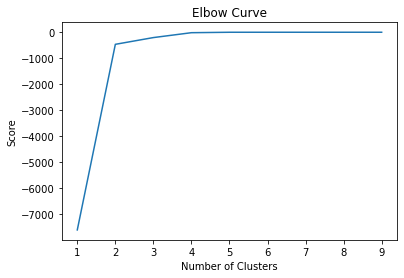

In [40]:
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [41]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head()

,zipcode,Latitude,Longitude,Total Patients,cluster_label
0,94565,38.0070008,-121.868574,29454,0
1,30044,34.000319,-84.1629724,22035,2
2,95823,38.4634804,-121.416546,21976,0
3,98012,47.8044871,-122.2090808,19112,0
4,19120,40.0374664,-75.1206684,19065,1


Abaixo podemos visualizar as localizações dos três clusters no mapa:

In [42]:
df_map = X

# create map using latitude and longitude values
map_ams = folium.Map(location=[latitude_ams, longitude_ams], zoom_start=4)
# add markers to map
for lat, lng in zip(df_map['Latitude'], df_map['Longitude']):
#     print(lat, lng)
    label = '{}, {}'.format(df_map['Latitude'], df_map['Longitude'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ams)

for lat, lng in zip(centers[:, 0], centers[:, 1]):

    folium.Marker(location=[lat, lng]).add_to(map_ams)

map_ams

In [43]:
clustered_data = df.merge(X, left_on='zipcode', right_on='zipcode')
clustered_data.head(5)

,zipcode,Latitude_x,Longitude_x,Total Patients_x,Total Testing Cost,Latitude_y,Longitude_y,Total Patients_y,cluster_label
0,94565,38.0070008,-121.868574,29454,9796639.14,38.0070008,-121.868574,29454,0
1,30044,34.000319,-84.1629724,22035,6259607.62,34.000319,-84.1629724,22035,2
2,95823,38.4634804,-121.416546,21976,8851073.04,38.4634804,-121.416546,21976,0
3,98012,47.8044871,-122.2090808,19112,5103858.03,47.8044871,-122.2090808,19112,0
4,19120,40.0374664,-75.1206684,19065,4737957.04,40.0374664,-75.1206684,19065,1


In [44]:
clustered_data.to_csv ('clustered_data.csv', index=None, header = True)

In [45]:
centers = kmeans.cluster_centers_
print(centers)

[[  42.85568526 -121.94032405]
 [  40.56630667  -74.10513603]
 [  33.90227803  -84.4391961 ]]


## Clustering ponderado


In [46]:
X_weighted = df.loc[:, ['zipcode','Latitude','Longitude', 'Total Patients']]

In [47]:
# Selecionando os 15 primeiros zip codes em relação do número total de pacientes
X_weighted = X_weighted.sort_values(['Total Patients'], ascending=[False])
#X_weighted = X_weighted[:15]

In [48]:
X_weighted.head(3)


,zipcode,Latitude,Longitude,Total Patients
0,94565,38.0070008,-121.868574,29454
1,30044,34.000319,-84.1629724,22035
2,95823,38.4634804,-121.416546,21976


### Create an elbow curve to select the optimal number of clusters - Weighted Clustering

In [49]:
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

lat_long = X_weighted[X_weighted.columns[1:3]]
lot_size = X_weighted[X_weighted.columns[3]]

sample_weight = lot_size

score = [kmeans[i].fit(lat_long, sample_weight = lot_size).score(lat_long) for i in range(len(kmeans))]

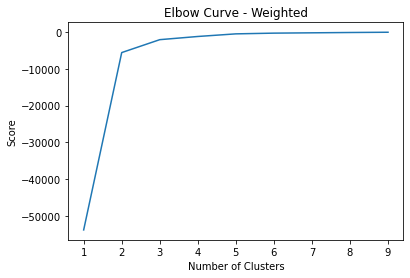

In [50]:
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.title('Elbow Curve - Weighted')

plt.show()

In [51]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head()

,zipcode,Latitude,Longitude,Total Patients,cluster_label
0,94565,38.0070008,-121.868574,29454,0
1,30044,34.000319,-84.1629724,22035,1
2,95823,38.4634804,-121.416546,21976,0
3,98012,47.8044871,-122.2090808,19112,0
4,19120,40.0374664,-75.1206684,19065,2


### Weighted Clustering using 3 as the optimal clusters


In [52]:
df_map = df

# create map of Amsterdam using latitude and longitude values
map_ams = folium.Map(location=[latitude_ams, longitude_ams], zoom_start=4)
# add markers to map
for lat, lng in zip(df_map['Latitude'], df_map['Longitude']):
#     print(lat, lng)
    label = '{}, {}'.format(df_map['Latitude'], df_map['Longitude'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ams)

for lat, lng in zip(centers[:, 0], centers[:, 1]):

    folium.Marker(location=[lat, lng]).add_to(map_ams)

map_ams

# Referências 

* https://eric.clst.org/tech/usgeojson/
* https://udsmapper.org/zip-code-to-zcta-crosswalk/